# The mutag benchmark isn't useful for graph learning
----------

So recently I've looked into graph learning for bioactivity prediction. One of my main reservations is that protein pockets don't care what the construction of a molecular graph is inside a ligand - they only care about what they can see, i.e. the positions of electron clouds in space\*.


While looking into it I found that the 'MUTAG' dataset is a commonly used benchmark for graph learning. It consists of 188 organic molecules that were tested [here](https://www.ncbi.nlm.nih.gov/pubmed/1995902) for mutagenicity. Do you think network effects between nodes (atoms) in the molecular graph are what define toxicity with respect to DNA? I don't, so let's take a look and see if graph analysis is suitable for these data.

Importantly, and differently to most graph learning papers, this involves looking at the actual data rather than sets of edgelists and nodelists. In this case, that means downloading the SMILES codes and visualizing the molecules. 


-------

\*Possible exception here for highly flexible ligands, where entropic factors have a large contribution to binding energy.

In [1]:
#everything:
import urllib 
import pandas as pd
import numpy as np

#chemistry:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors

#learning:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#plotting:
from seaborn import kdeplot
import matplotlib.pyplot as plt
%matplotlib inline


/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
##Load the MUTAG SMILES codes 

response = urllib.request.urlopen('ftp://ftp.ics.uci.edu/pub/baldig/learning/mutag/mutag_188_data.can')
smiles = response.read()
smiles = [i.split()[0] for i in smiles.decode().split('\n')[:-1]]
print('Smiles codes:', smiles[:5], '\n')

response = urllib.request.urlopen('ftp://ftp.ics.uci.edu/pub/baldig/learning/mutag/mutag_188_target.txt')
labels = response.read()
labels = ((np.array(labels.decode().split('\n')[:-1]).astype(int)+1) / 2).astype(int)
print('Mutagenicitiy labels:', labels[:10], '\n')

Smiles codes: ['c1ccc2c(c1)ccc3c2ccc(c3)[N+](=O)[O-]', 'c1cc2cccnc2c(c1)[N+](=O)[O-]', 'c1cc2c(cccn2)c(c1)[N+](=O)[O-]', 'c1ccc-2c(c1)-c3cccc4c3c2c(cc4)[N+](=O)[O-]', 'c1cc(c(cc1F)[N+](=O)[O-])F'] 

Mutagenicitiy labels: [1 0 0 1 0 1 0 1 0 1] 



Two of the SMILES codes don't agree with RDKit, so they get replaced. [Thanks to Brian Cole from the RDKit mailing list](https://sourceforge.net/p/rdkit/mailman/message/36939161/) for the explanation!

In [3]:
#couple of unparseable SMILES
mols = np.array([Chem.MolFromSmiles(i) for i in smiles])
(mols==None).nonzero()

(array([ 82, 187]),)

In [4]:
#replace them with correct smiles:
two_nitrocarbazole = 'O=[N+]([O-])c1ccc2[nH]c3ccccc3c2c1'
three_nitrocarbazole = 'O=[N+]([O-])c1ccc2c(c1)[nH]c1ccccc12'

mols[82] = Chem.MolFromSmiles(two_nitrocarbazole)
mols[187]= Chem.MolFromSmiles(three_nitrocarbazole)

## Visualize the graphs

Here it becomes pretty obvious what causes a molecule in this dataset to be mutagenic. 

### Molecules that are mutagenic:

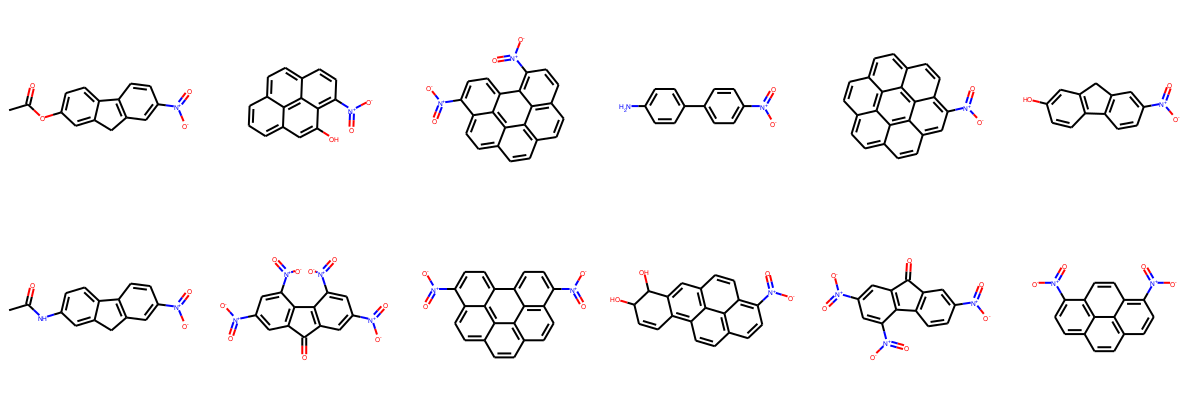

In [5]:
Draw.MolsToGridImage(np.random.choice(mols[labels==1], 12, replace=False), molsPerRow=6)

### Molecules that are not mutagenic:

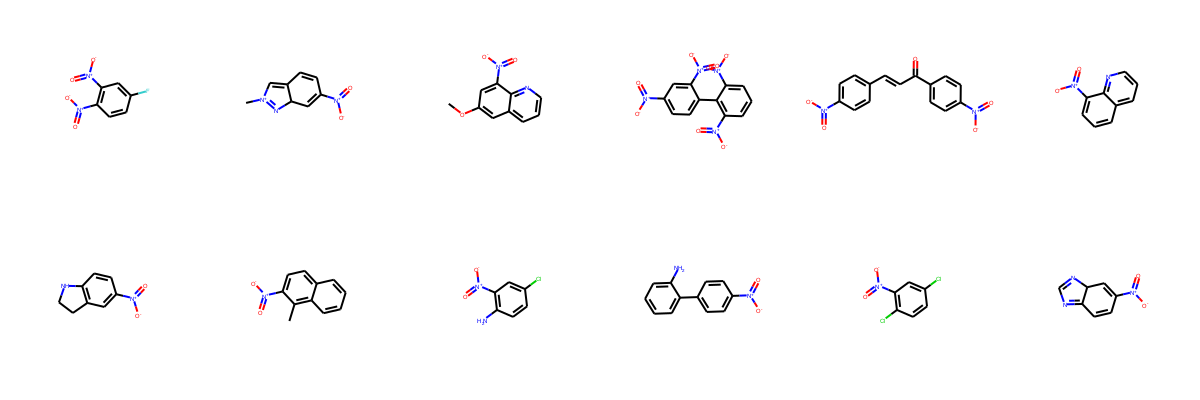

In [6]:
Draw.MolsToGridImage(np.random.choice(mols[labels==0], 12, replace=False), molsPerRow=6)

## Check it out:

With the disclaimer that I'm not an expert in toxicology, the mutagenic ones are known as polycyclic aromatic hydrocarbons, which get metabolised into DNA-binding products. 

The molecules that are not mutagenic are that way because they have fewer rings, meaning you just have to count the number of atoms (or even better, the number of rings) to get pretty competitive results, using just a single feature, compared to recent graph learning techniques.


The below counts the number of atoms for each molecule, and performs 100 bootstrapping repeats of testing a logistic regression classifier with 10% of the data as hold-out. I'm using the the 'accuracy' score to compare with graph learning papers, but with about 1:2 class imbalance 'average precision' might be better.

Observe:

In [7]:
#count the number of atoms:
features = np.array([mol.GetNumAtoms() for mol in mols])

#Even better!!!
#count the number of rigs
#features = np.array([rdMolDescriptors.CalcNumRings(mol) for mol in mols])


Text(0.5, 0, 'Number of nodes')

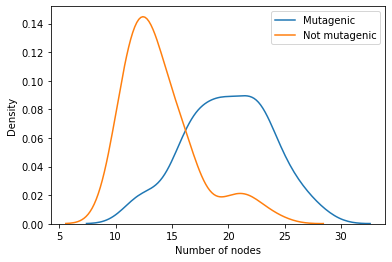

In [8]:
###Plot the distributions of the number of atoms in each class:

kdeplot(features[labels==1], label='Mutagenic')
kdeplot(features[labels==0], label='Not mutagenic')
plt.ylabel('Density')
plt.xlabel('Number of nodes')

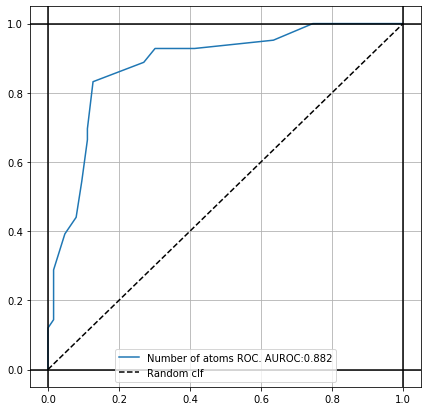

In [9]:
##The above plot is the origin of an ROC curve. Plot the ROC curve and print AUROC:

from sklearn.metrics import roc_curve, roc_auc_score
a,b,c= roc_curve(labels, features)
plt.figure(figsize=(7,7))
plt.plot(a,b, label=f'Number of atoms ROC. AUROC:{np.around(roc_auc_score(labels, features), 3)}')
plt.plot([0,1],[0,1], '--k', label='Random clf')

plt.axvline(0, c='k')
plt.axvline(1, c='k')
plt.axhline(0, c='k')
plt.axhline(1, c='k')
plt.legend()
plt.grid()

In [10]:
##Perform 100 bootstrapping repeats, training a logistic regression classifier
##on the single feature (number of atoms)


accuracies = list()
num_test = int(0.1*labels.shape[0]) #ten percent hold out
for _ in range(100):
    indices = np.arange(labels.shape[0])
    np.random.shuffle(indices)
    test_indices = indices[:num_test]
    train_indices = indices[num_test:]
    
    x_train = features[train_indices][:,None] #reshape single feature for sklearn
    y_train = labels[train_indices]
    
    x_test = features[test_indices][:,None] #reshape single feature for sklearn
    y_test = labels[test_indices]
    
    clf = LogisticRegression(solver='lbfgs', C=1000)
    clf.fit(x_train, y_train)
    
    preds = clf.predict(x_test)
    accuracies.append(accuracy_score(y_test, preds))
    
print('Mean accuracy:', np.mean(accuracies))

Mean accuracy: 0.841111111111111


### Plot in comparison to other techniques:


I pulled the accuracy scores for other graph learning techniques from a recent graph learning paper that I like for it's simplicity and how that complements the permutation invariance.
- Verma, S., & Zhang, Z. L. (2017). Hunt for the unique, stable, sparse and fast feature learning on graphs. In Advances in Neural Information Processing Systems (pp. 88-98).

Text(0, 0.5, 'Density')

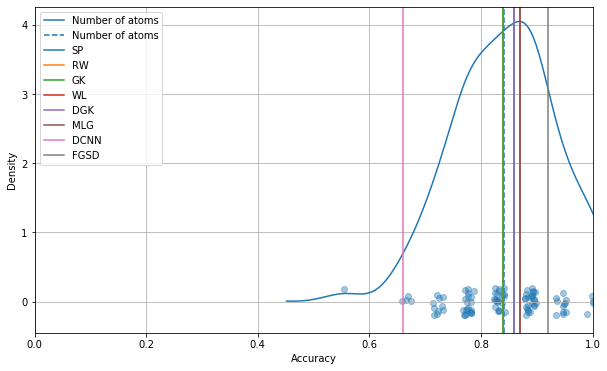

In [11]:
plt.figure(figsize=(10,6))
kdeplot(accuracies, label='Number of atoms')
plt.axvline(np.mean(accuracies), label="Number of atoms", linestyle='--')
plt.scatter(accuracies+np.random.uniform(-0.01,0.01, len(accuracies)), 
            np.random.uniform(-0.2,0.2, len(accuracies)), alpha=0.4)
plt.xlim(0,1)
plt.grid()
plt.axvline(0.86, label='SP', c='C0')
plt.axvline(0.84, label='RW', c='C1')
plt.axvline(0.84, label='GK', c='C2')
plt.axvline(0.87, label='WL', c='C3')
plt.axvline(0.86, label='DGK', c='C4')
plt.axvline(0.87, label='MLG', c='C5')
plt.axvline(0.66, label='DCNN', c='C6')
plt.axvline(0.92, label='FGSD', c='C7')
plt.legend()

plt.xlabel('Accuracy')
plt.ylabel('Density')

# Takeaway:

Training on the number of atoms doesn't beat recent graph learning techniques but it gets pretty close. This doesn't mean those techniques are bad, but I think it does mean the MUTAG benchmark isn't useful here. Is it really worthwhile applying the Deep Graph Kernel learning algorithm to this dataset for a couple percentage points above such a simple baseline?

- It raises the question of why you would want to apply graph classification techniques to the MUTAG dataset at all. The network of nodes and edges doesn't appear to be causative of mutagenicity.

- For me, visualizing the dataset was important to get some meaning from the results. 

I tried to visualize the molecules in another common benchmark (NCI1) but I can't find the SMILES codes anywhere. The NCI1 moleules were selected from a larger dataset in a paper from 2008, but the data are only stored as nodes and edges now and the node labels don't reference the actual atomic identities. Perhaps, then, any interpretaion of the results for NCI1 are lost to time. 